## 训练日志

![image.png](training_log.png)
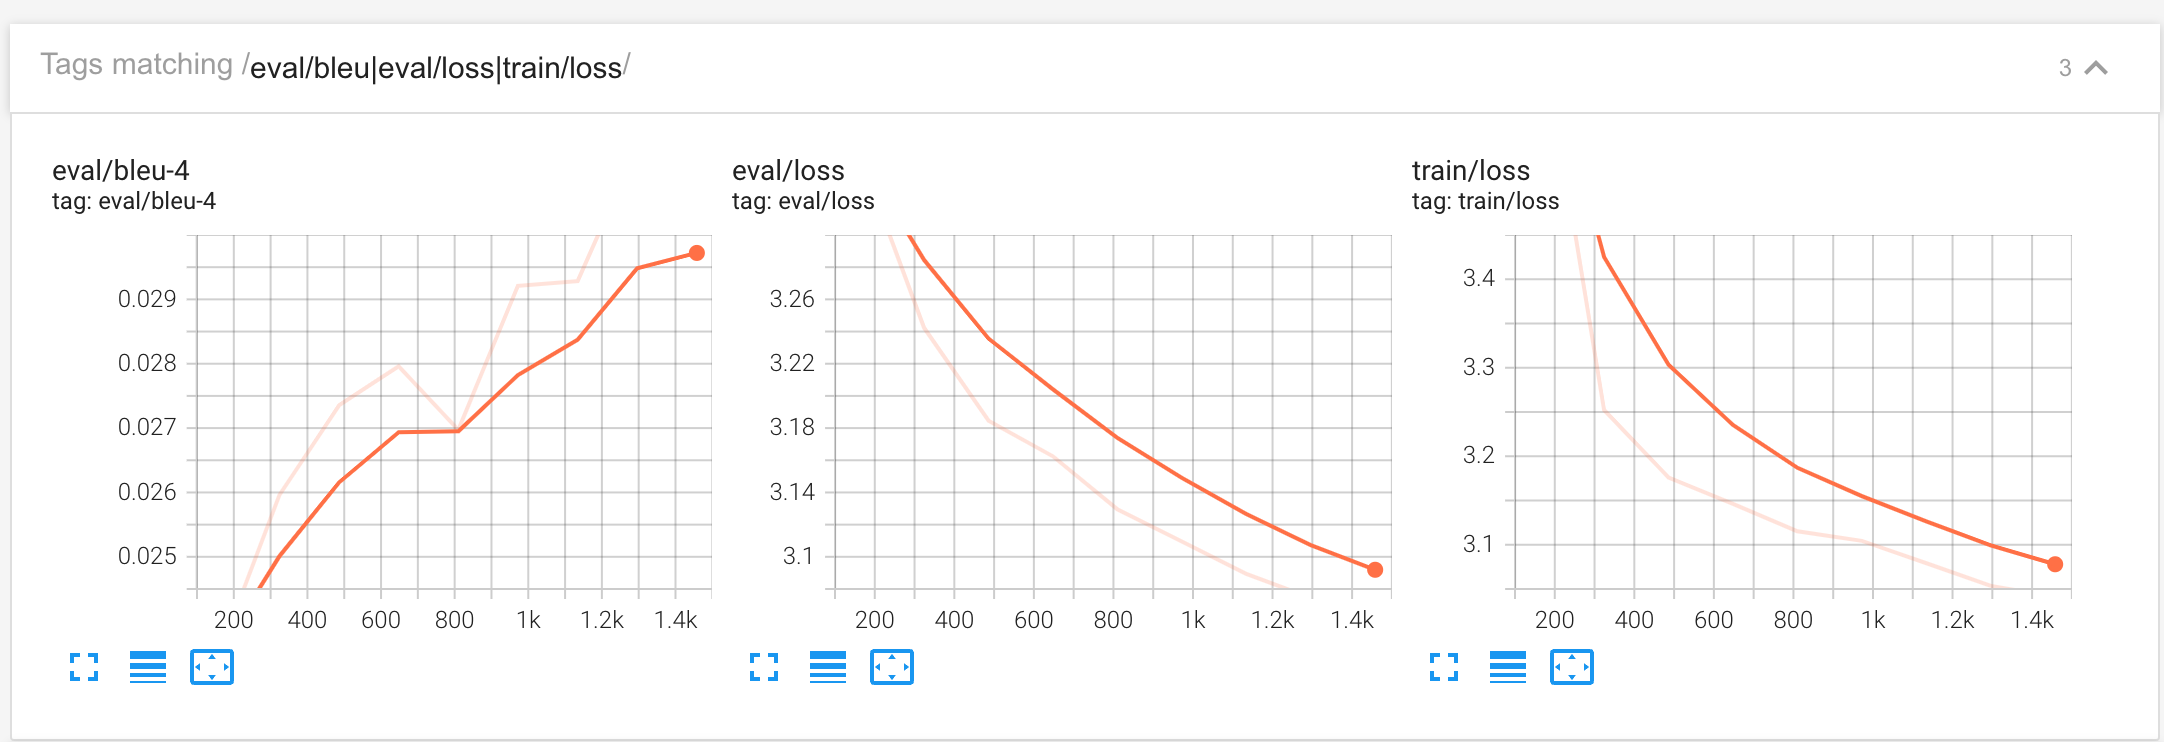

## 通过推理验证AdvertiseGen数据集微调后的结果

In [1]:
# %env HF_ENDPOINT=https://hf-mirror.com
%env HF_HOME=/root/autodl-tmp/hf
%env HF_HUB_CACHE=/root/autodl-tmp/hf

env: HF_HOME=/root/autodl-tmp/hf
env: HF_HUB_CACHE=/root/autodl-tmp/hf


In [2]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [3]:
adapter_dir = '/root/autodl-tmp/models/THUDM/chatglm3-6b'
model_name='THUDM/chatglm3-6b'
import torch
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel, PeftConfig
peft_config = PeftConfig.from_pretrained(adapter_dir)

In [4]:
peft_config.base_model_name_or_path

'THUDM/chatglm3-6b'

In [5]:
q_config = BitsAndBytesConfig(load_in_4bit=True,
                              bnb_4bit_quant_type='nf4',
                              bnb_4bit_use_double_quant=True,
                              bnb_4bit_compute_dtype=torch.float32)

base_model = AutoModel.from_pretrained(peft_config.base_model_name_or_path,
                                       quantization_config=q_config,
                                       trust_remote_code=True,
                                       device_map='auto',
                                       revision='b098244'
                                      )
base_model.requires_grad_(False)
base_model.eval()

/root/miniconda3/envs/llm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

ChatGLMForConditionalGeneration(
  (transformer): ChatGLMModel(
    (embedding): Embedding(
      (word_embeddings): Embedding(65024, 4096)
    )
    (rotary_pos_emb): RotaryEmbedding()
    (encoder): GLMTransformer(
      (layers): ModuleList(
        (0-27): 28 x GLMBlock(
          (input_layernorm): RMSNorm()
          (self_attention): SelfAttention(
            (query_key_value): Linear4bit(in_features=4096, out_features=4608, bias=True)
            (core_attention): CoreAttention(
              (attention_dropout): Dropout(p=0.0, inplace=False)
            )
            (dense): Linear4bit(in_features=4096, out_features=4096, bias=False)
          )
          (post_attention_layernorm): RMSNorm()
          (mlp): MLP(
            (dense_h_to_4h): Linear4bit(in_features=4096, out_features=27392, bias=False)
            (dense_4h_to_h): Linear4bit(in_features=13696, out_features=4096, bias=False)
          )
        )
      )
      (final_layernorm): RMSNorm()
    )
    (output_la

In [6]:
input_text = '类型#大衣*版型#高挑*风格#商务*风格#成熟*图案#纯色*图案#撞色*领部#高领*长度#风衣*颜色#深灰色'
print(f'输入：\n{input_text}')
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path, trust_remote_code=True)

输入：
类型#大衣*版型#高挑*风格#商务*风格#成熟*图案#纯色*图案#撞色*领部#高领*长度#风衣*颜色#深灰色


Setting eos_token is not supported, use the default one.
Setting pad_token is not supported, use the default one.
Setting unk_token is not supported, use the default one.


In [7]:
response, history = base_model.chat(tokenizer=tokenizer, query=input_text)
print(f'ChatGLM3-6B 微调前：\n{response}')

/root/miniconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


ChatGLM3-6B 微调前：
这款深灰色的纯色高领风衣，版型设计高挑，适合商务场合穿着，展现出成熟稳重的风格。衣服采用纯色设计，简约大气，而高领设计则增加了整体的立体感，显得更加时尚。撞色的设计也是这款风衣的一大亮点，让整体造型更具张力和吸引力。这款深灰色的风衣长度适中，既不会显得过于沉闷，也不会显得过于轻挑，刚刚好能够展现出你的魅力。


In [8]:
model = PeftModel.from_pretrained(base_model, adapter_dir)
response, history = model.chat(tokenizer=tokenizer, query=input_text)
print(f'ChatGLM3-6B 微调后: \n{response}')

ChatGLM3-6B 微调后: 
深灰色的风衣给人成熟稳重的感觉，商务范儿十足。纯色的色调百搭，高领的设计让这款风衣看起来更有气质，且不显臃肿。撞色的袖口和下摆设计，增添一丝时尚感。
